# 通过OCR实现验证码识别

**作者:** [GT_老张](https://github.com/GT-ZhangAcer)  

**时间:** 2021.01

**摘要:** 本篇将介绍如何通过飞桨实现简单的CRNN+CTC自定义数据集OCR识别模型，数据集采用[CaptchaDataset](https://github.com/GT-ZhangAcer/CaptchaDataset)中OCR部分的9453张图像，其中前8453张图像在本案例中作为训练集，后1000张则作为测试集。  
在更复杂的场景中推荐使用[PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR)产出工业级模型，模型轻量且精度大幅提升。  
同样也可以在[PaddleHub](https://www.paddlepaddle.org.cn/hubdetail?name=chinese_ocr_db_crnn_mobile&en_category=TextRecognition)中快速使用PaddleOCR。



## 一、环境配置

本教程基于Paddle 2.0 编写，如果您的环境不是本版本，请先参考官网[安装](https://www.paddlepaddle.org.cn/install/quick) Paddle 2.0 。

In [ ]:
import paddle
print(paddle.__version__)

2.0.0


## 二、自定义数据集读取器

常见的开发任务中，我们并不一定会拿到标准的数据格式，好在我们可以通过自定义Reader的形式来随心所欲读取自己想要数据。 

设计合理的Reader往往可以带来更好的性能，我们可以将读取标签文件列表、制作图像文件列表等必要操作在`__init__`特殊方法中实现。这样就可以在实例化`Reader`时装入内存，避免使用时频繁读取导致增加额外开销。同样我们可以在`__getitem__`特殊方法中实现如图像增强、归一化等个性操作，完成数据读取后即可释放该部分内存。    
需要我们注意的是，如果不能保证自己数据十分纯净，可以通过`try`和`expect`来捕获异常并指出该数据的位置。当然也可以制定一个策略，使其在发生数据读取异常后依旧可以正常进行训练。  

### 2.1 数据展示
![](./images/image1.png)

点此[快速获取本节数据集](https://aistudio.baidu.com/aistudio/datasetdetail/57285)，待数据集下载完毕后可使用`!unzip OCR_Dataset.zip -d data/`命令或熟悉的解压软件进行解压，待数据准备工作完成后修改本文“训练准备”中的`DATA_PATH = 解压后数据集路径`。

In [ ]:
# 解压数据集
!unzip OCR_Dataset.zip -d data/

In [ ]:
import os

import PIL.Image as Image
import numpy as np
from paddle.io import Dataset

# 图片信息配置 - 通道数、高度、宽度
IMAGE_SHAPE_C = 3
IMAGE_SHAPE_H = 30
IMAGE_SHAPE_W = 70
# 数据集图片中标签长度最大值设置 - 因图片中均为4个字符，故该处填写为4即可
LABEL_MAX_LEN = 4


class Reader(Dataset):
    def __init__(self, data_path: str, is_val: bool = False):
        """
        数据读取Reader
        :param data_path: Dataset路径
        :param is_val: 是否为验证集
        """
        super().__init__()
        self.data_path = data_path
        # 读取Label字典
        with open(os.path.join(self.data_path, "label_dict.txt"), "r", encoding="utf-8") as f:
            self.info = eval(f.read())
        # 获取文件名列表
        self.img_paths = [img_name for img_name in self.info]
        # 将数据集后1000张图片设置为验证集，当is_val为真时img_path切换为后1000张
        self.img_paths = self.img_paths[-1000:] if is_val else self.img_paths[:-1000]

    def __getitem__(self, index):
        # 获取第index个文件的文件名以及其所在路径
        file_name = self.img_paths[index]
        file_path = os.path.join(self.data_path, file_name)
        # 捕获异常 - 在发生异常时终止训练
        try:
            # 使用Pillow来读取图像数据
            img = Image.open(file_path)
            # 转为Numpy的array格式并整体除以255进行归一化
            img = np.array(img, dtype="float32").reshape((IMAGE_SHAPE_C, IMAGE_SHAPE_H, IMAGE_SHAPE_W)) / 255
        except Exception as e:
            raise Exception(file_name + "\t文件打开失败，请检查路径是否准确以及图像文件完整性，报错信息如下:\n" + str(e))
        # 读取该图像文件对应的Label字符串，并进行处理
        label = self.info[file_name]
        label = list(label)
        # 将label转化为Numpy的array格式
        label = np.array(label, dtype="int32").reshape(LABEL_MAX_LEN)

        return img, label

    def __len__(self):
        # 返回每个Epoch中图片数量
        return len(self.img_paths)

## 三、模型配置

### 3.1 定义模型结构以及模型输入

模型方面使用的简单的CRNN-CTC结构，输入形为CHW的图像在经过CNN->Flatten->Linear->RNN->Linear后输出图像中每个位置所对应的字符概率。考虑到CTC解码器在面对图像中元素数量不一、相邻元素重复时会存在无法正确对齐等情况，故额外添加一个类别代表“分隔符”进行改善。

CTC相关论文：[Connectionist Temporal Classification: Labelling Unsegmented Sequence Data with Recurrent Neu](http://people.idsia.ch/~santiago/papers/icml2006.pdf) 

![](./images/image2.png)

网络部分，因本篇采用数据集较为简单且图像尺寸较小并不适合较深层次网络。若在对尺寸较大的图像进行模型构建，可以考虑使用更深层次网络/注意力机制来完成。当然也可以通过目标检测形式先检出文本位置，然后进行OCR部分模型构建。

![](./images/image3.png)

<a href="https://github.com/PaddlePaddle/PaddleOCR">PaddleOCR效果图</a>
</p>

In [ ]:
import paddle

# 分类数量设置 - 因数据集中共包含0~9共10种数字+分隔符，所以是11分类任务
CLASSIFY_NUM = 11

# 定义输入层，shape中第0维使用-1则可以在预测时自由调节batch size
input_define = paddle.static.InputSpec(shape=[-1, IMAGE_SHAPE_C, IMAGE_SHAPE_H, IMAGE_SHAPE_W],
                                   dtype="float32",
                                   name="img")

# 定义网络结构
class Net(paddle.nn.Layer):
    def __init__(self, is_infer: bool = False):
        super().__init__()
        self.is_infer = is_infer

        # 定义一层3x3卷积+BatchNorm
        self.conv1 = paddle.nn.Conv2D(in_channels=IMAGE_SHAPE_C,
                                  out_channels=32,
                                  kernel_size=3)
        self.bn1 = paddle.nn.BatchNorm2D(32)
        # 定义一层步长为2的3x3卷积进行下采样+BatchNorm
        self.conv2 = paddle.nn.Conv2D(in_channels=32,
                                  out_channels=64,
                                  kernel_size=3,
                                  stride=2)
        self.bn2 = paddle.nn.BatchNorm2D(64)
        # 定义一层1x1卷积压缩通道数，输出通道数设置为比LABEL_MAX_LEN稍大的定值可获取更优效果，当然也可设置为LABEL_MAX_LEN
        self.conv3 = paddle.nn.Conv2D(in_channels=64,
                                  out_channels=LABEL_MAX_LEN + 4,
                                  kernel_size=1)
        # 定义全连接层，压缩并提取特征（可选）
        self.linear = paddle.nn.Linear(in_features=429,
                                   out_features=128)
        # 定义RNN层来更好提取序列特征，此处为双向LSTM输出为2 x hidden_size，可尝试换成GRU等RNN结构
        self.lstm = paddle.nn.LSTM(input_size=128,
                               hidden_size=64,
                               direction="bidirectional")
        # 定义输出层，输出大小为分类数
        self.linear2 = paddle.nn.Linear(in_features=64 * 2,
                                    out_features=CLASSIFY_NUM)

    def forward(self, ipt):
        # 卷积 + ReLU + BN
        x = self.conv1(ipt)
        x = paddle.nn.functional.relu(x)
        x = self.bn1(x)
        # 卷积 + ReLU + BN
        x = self.conv2(x)
        x = paddle.nn.functional.relu(x)
        x = self.bn2(x)
        # 卷积 + ReLU
        x = self.conv3(x)
        x = paddle.nn.functional.relu(x)
        # 将3维特征转换为2维特征 - 此处可以使用reshape代替
        x = paddle.tensor.flatten(x, 2)
        # 全连接 + ReLU
        x = self.linear(x)
        x = paddle.nn.functional.relu(x)
        # 双向LSTM - [0]代表取双向结果，[1][0]代表forward结果,[1][1]代表backward结果，详细说明可在官方文档中搜索'LSTM'
        x = self.lstm(x)[0]
        # 输出层 - Shape = (Batch Size, Max label len, Signal) 
        x = self.linear2(x)

        # 在计算损失时ctc-loss会自动进行softmax，所以在预测模式中需额外做softmax获取标签概率
        if self.is_infer:
            # 输出层 - Shape = (Batch Size, Max label len, Prob) 
            x = paddle.nn.functional.softmax(x)
            # 转换为标签
            x = paddle.argmax(x, axis=-1)
        return x

## 四、训练准备

### 4.1 定义label输入以及超参数
监督训练需要定义label，预测则不需要该步骤。

In [ ]:
# 数据集路径设置
DATA_PATH = "./data/OCR_Dataset"
# 训练轮数
EPOCH = 10
# 每批次数据大小
BATCH_SIZE = 16

label_define = paddle.static.InputSpec(shape=[-1, LABEL_MAX_LEN],
                                    dtype="int32",
                                    name="label")

### 4.2 定义CTC Loss

了解CTC解码器效果后，我们需要在训练中让模型尽可能接近这种类型输出形式，那么我们需要定义一个CTC Loss来计算模型损失。不必担心，在飞桨框架中内置了多种Loss，无需手动复现即可完成损失计算。
 
使用文档：[CTCLoss](https://www.paddlepaddle.org.cn/documentation/docs/zh/2.0-beta/api/paddle/nn/functional/loss/ctc_loss_cn.html#ctc-loss)

In [ ]:
class CTCLoss(paddle.nn.Layer):
    def __init__(self):
        """
        定义CTCLoss
        """
        super().__init__()

    def forward(self, ipt, label):
        input_lengths = paddle.full(shape=[BATCH_SIZE, 1],fill_value=LABEL_MAX_LEN + 4,dtype= "int64")
        label_lengths = paddle.full(shape=[BATCH_SIZE, 1],fill_value=LABEL_MAX_LEN,dtype= "int64")
        # 按文档要求进行转换dim顺序
        ipt = paddle.tensor.transpose(ipt, [1, 0, 2])
        # 计算loss
        loss = paddle.nn.functional.ctc_loss(ipt, label, input_lengths, label_lengths, blank=10)
        return loss

### 4.3 实例化模型并配置优化策略

In [ ]:
# 实例化模型
model = paddle.Model(Net(), inputs=input_define, labels=label_define)

In [ ]:
# 定义优化器
optimizer = paddle.optimizer.Adam(learning_rate=0.0001, parameters=model.parameters())

# 为模型配置运行环境并设置该优化策略
model.prepare(optimizer=optimizer,
                loss=CTCLoss())

## 五、开始训练


In [31]:
# 执行训练
model.fit(train_data=Reader(DATA_PATH),
            eval_data=Reader(DATA_PATH, is_val=True),
            batch_size=BATCH_SIZE,
            epochs=EPOCH,
            save_dir="output/",
            save_freq=1,
            verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/10
step 529/529 [==============================] - loss: 0.1299 - 10ms/step        
save checkpoint at /home/aistudio/output/0
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 63/63 [==============================] - loss: 0.1584 - 6ms/step        
Eval samples: 1000
Epoch 2/10
step 529/529 [==============================] - loss: 0.0300 - 9ms/step         
save checkpoint at /home/aistudio/output/1
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 63/63 [==============================] - loss: 0.0663 - 6ms/step        
Eval samples: 1000
Epoch 3/10
step 529/529 [==============================] - loss: 0.2056 - 9ms/step        
save checkpoint at /home/aistudio/output/2
Eval begin...
The loss value printed in the l

## 六、预测前准备

### 6.1 像定义训练Reader一样定义预测Reader

In [32]:
# 与训练近似，但不包含Label
class InferReader(Dataset):
    def __init__(self, dir_path=None, img_path=None):
        """
        数据读取Reader(预测)
        :param dir_path: 预测对应文件夹（二选一）
        :param img_path: 预测单张图片（二选一）
        """
        super().__init__()
        if dir_path:
            # 获取文件夹中所有图片路径
            self.img_names = [i for i in os.listdir(dir_path) if os.path.splitext(i)[1] == ".jpg"]
            self.img_paths = [os.path.join(dir_path, i) for i in self.img_names]
        elif img_path:
            self.img_names = [os.path.split(img_path)[1]]
            self.img_paths = [img_path]
        else:
            raise Exception("请指定需要预测的文件夹或对应图片路径")

    def get_names(self):
        """
        获取预测文件名顺序 
        """
        return self.img_names

    def __getitem__(self, index):
        # 获取图像路径
        file_path = self.img_paths[index]
        # 使用Pillow来读取图像数据并转成Numpy格式
        img = Image.open(file_path)
        img = np.array(img, dtype="float32").reshape((IMAGE_SHAPE_C, IMAGE_SHAPE_H, IMAGE_SHAPE_W)) / 255
        return img

    def __len__(self):
        return len(self.img_paths)

### 6.2 参数设置

In [33]:
# 待预测目录 - 可在测试数据集中挑出\b3张图像放在该目录中进行推理
INFER_DATA_PATH = "./sample_img"
# 训练后存档点路径 - final 代表最终训练所得模型
CHECKPOINT_PATH = "./output/final.pdparams"
# 每批次处理数量
BATCH_SIZE = 32

### 6.3 展示待预测数据

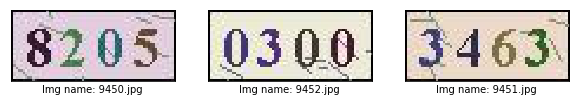

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
sample_idxs = np.random.choice(50000, size=25, replace=False)

for img_id, img_name in enumerate(os.listdir(INFER_DATA_PATH)):
    plt.subplot(1, 3, img_id + 1)
    plt.xticks([])
    plt.yticks([])
    im = Image.open(os.path.join(INFER_DATA_PATH, img_name))
    plt.imshow(im, cmap=plt.cm.binary)
    plt.xlabel("Img name: " + img_name)
plt.show()

## 七、开始预测
> 飞桨2.0 CTC Decoder 相关API正在迁移中，本节暂时使用简易版解码器。

In [35]:
# 编写简易版解码器
def ctc_decode(text, blank=10):
    """
    简易CTC解码器
    :param text: 待解码数据
    :param blank: 分隔符索引值
    :return: 解码后数据
    """
    result = []
    cache_idx = -1
    for char in text:
        if char != blank and char != cache_idx:
            result.append(char)
        cache_idx = char
    return result


# 实例化推理模型
model = paddle.Model(Net(is_infer=True), inputs=input_define)
# 加载训练好的参数模型
model.load(CHECKPOINT_PATH)
# 设置运行环境
model.prepare()

# 加载预测Reader
infer_reader = InferReader(INFER_DATA_PATH)
img_names = infer_reader.get_names()
results = model.predict(infer_reader, batch_size=BATCH_SIZE)
index = 0
for text_batch in results[0]:
    for prob in text_batch:
        out = ctc_decode(prob, blank=10)
        print(f"文件名：{img_names[index]}，推理结果为：{out}")
        index += 1

Predict begin...
step 1/1 [==============================] - 6ms/step
Predict samples: 3
文件名：9450.jpg，推理结果为：[8, 2, 0, 5]
文件名：9452.jpg，推理结果为：[0, 3, 0, 0]
文件名：9451.jpg，推理结果为：[3, 4, 6, 3]
